In [1]:
# Imports and parameters
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib.patches import Ellipse, Rectangle
import seaborn as sns
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.io.img_tiles import MapboxTiles
from   scipy import stats
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from   statsmodels.stats.outliers_influence import summary_table
from   IPython.display import display
from   IPython.display import HTML
from   sklearn.metrics.pairwise import paired_euclidean_distances
from   sklearn.preprocessing import StandardScaler
import plotly.plotly as py
import plotly.graph_objs as go
from   sklearn.cluster import KMeans
from   sklearn.decomposition import PCA

ci = 0.95 # Set size of confidence interval. 95% = 0.95
splitdate = 1914 # For era comparisons

# Define colors for use throughout
colors = {
    'Hathi':     'darkblue', 
    'Foreign':   'darkred',
    'London':    'darkgreen',
    'Prominent': 'purple',
    'White':     'steelblue', 
    'Nonwhite':  'darkorange',
    'Fiction':   'darkcyan',
    'Nonfiction':'saddlebrown',
    'male':      'darkslateblue',  
    'female':    'orange',
    'androg':    'darkviolet',
    'mostly_male':'slateblue',
    'mostly_female':'orangered',
    'unknown':   'darkkhaki'
}

# Directories for input and output
figDir     = os.path.join('figures')
resultsDir = os.path.join('results')
dataDir    = os.path.join('datasets')
os.makedirs(figDir, exist_ok=True)
os.makedirs(resultsDir, exist_ok=True)
os.makedirs(dataDir, exist_ok=True)

mapbox_key_file = '/Users/mwilkens/Google Drive/Private/mapbox-api-key.txt'

sns.set()
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [2]:
geo = pd.read_csv(
    os.path.join(dataDir, 'geo.tsv.gz'),
    sep='\t', 
    compression='gzip',
    low_memory=False
)
geo.head()

corpus                htid   text_string lang  occurs            author  \
0  Hathi  uc1.32106010050240  100th street   en       1     Ellroy, James   
1  Hathi  mdp.49015002580182  110th street   en       1               NaN   
2  Hathi  uc1.32106002116355  110th street   en       1  Himes, Chester B   
3  Hathi        uc1.b4079824  110th street   en       1     Wolfe, Thomas   
4  Hathi  mdp.39015029554741  110th street   en       1               NaN   

                                               title  pub_date gender  \
0                        CLandestine / James Ellroy.      1984   male   
1  The Oxford book of American short stories / ed...      1994    NaN   
2             The big gold dream [by] Chester Himes.      1968   male   
3  Selections from the works of Thomas Wolfe. ed....      1952   male   
4  The Oxford book of American short stories / ed...      1992    NaN   

     genre    ...            route post_code natural_feature  \
0  Fiction    ...     100th Street     50322             NaN   
1  Fiction    ...     110th Street       NaN             NaN   
2  Fiction    ...     110th Street       NaN             NaN   
3  Fiction    ...     110th Street       NaN             NaN   
4  Fiction    ...     110th Street       NaN             NaN   

  point_of_interest colloquial_area continent other        lat        lon  \
0               NaN             NaN       NaN   NaN  41.629257 -93.755830   
1               NaN             NaN       NaN   NaN  39.667364 -95.564081   
2               NaN             NaN       NaN   NaN  39.667364 -95.564081   
3               NaN             NaN       NaN   NaN  39.667364 -95.564081   
4               NaN             NaN       NaN   NaN  39.667364 -95.564081   

  wordcount  
0    137372  
1    363317  
2     68744  
3    263612  
4    360224  

[5 rows x 43 columns]

In [3]:
geo['occurs_100k'] = geo['occurs']*100000/geo['wordcount']
not_in_london = frozenset([    
    'thames',
    'thames river',
    'river thames',
    'kew gardens'
])
# Group the data by corpus and generate subsets to be used below
corpus_grouped        = geo.groupby('corpus')
corpus_gb_grouped     = geo.loc[(geo.country_short=='GB')].groupby('corpus')
corpus_nongb_grouped  = geo.loc[(geo.country_short!='GB')].groupby('corpus')
corpus_london_grouped = geo.loc[(geo.country_short == 'GB') &
                                 ((geo.admin_2 == 'Greater London') |
                                 (geo.text_string.isin(not_in_london)))].groupby('corpus')

# Build dataframe that's just the corpus with metadata, not geo.
# Much smaller than full dataset, useful for some quickies below
metadata = geo[['htid', 'corpus','author', 'title', 'pub_date', 
                 'genre', 'gender', 'white', 'origin_area', 'origin_nation',
                 'wordcount'
                ]].drop_duplicates()
metadata_grouped = metadata.groupby('corpus')

print("Unique HTIDs across all corpora:", geo.htid.nunique())
print("\nVolumes per corpus:", corpus_grouped.htid.nunique())

Unique HTIDs across all corpora: 47753

Volumes per corpus: corpus
Foreign        130
Hathi        47128
London         171
Prominent      576
Name: htid, dtype: int64


In [7]:
# Function to generate bubble maps of arbitrary data
try:
    mapbox_key = open(mapbox_key_file).read().strip()
except:
    print('Cannot get MapBox API key. This will go badly.')

def bubblemap(figsz, lats, lons, sizes, color, extent, proj, hires, name):
    '''Takes lists of lats, lons, and sizes.
    figsz is a tuple in inches, e.g.: (12, 6)
    extent is a list of degrees for viewport, e.g.: [-170, 170, -60, 80]
    proj is a cartopy projection: ccrs.Robinson() or ccrs.OSGB()
    hires is boolean. False for world maps, true for country maps.
    Saves output file and displays map, but returns nothing.
    '''
    fig = plt.figure(figsize=figsz)
    ax = plt.axes(projection=proj)
    
    if extent:
        ax.set_extent(extent)
    #sizes      = [i/50 for i in sizes]

    plt.scatter(lons, lats, s=sizes, linewidths=0,
                color=color, marker='o', alpha=0.4, transform=ccrs.Geodetic())
    if hires:
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
        ax.add_feature(coast, edgecolor='black')
    else:
        ax.add_feature(cfeature.COASTLINE, linewidth=1.5, alpha=1.0)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
    fig.canvas.draw()
    plt.tight_layout()
    plt.savefig(os.path.join(figDir, name)+'.png', dpi=300)

In [8]:
# A function to plot London city maps. Should roll into bubblemap(), but lazy.
def bubblemap_london(figsz, lats, lons, sizes, color, extent, name):
    '''Takes lists of lats, lons, and sizes.
    figsz is a tuple of dimensions in inches, e.g.: (12,12)
    Saves output file and displays map, but returns nothing.
    '''
    fig = plt.figure(figsize=figsz)
    imagery = MapboxTiles(mapbox_key, 'mapbox.light')
    ax = plt.axes(projection=imagery.crs)
    if extent:
        ax.set_extent(extent)
    ax.add_image(imagery, 14)
    
    plt.scatter(lons, lats, s=sizes, linewidths=0,
                color=color, marker='o', alpha=0.4, transform=ccrs.Geodetic())
    fig.canvas.draw()
    plt.tight_layout()
    plt.savefig(os.path.join(figDir, name)+'.png', dpi=300)

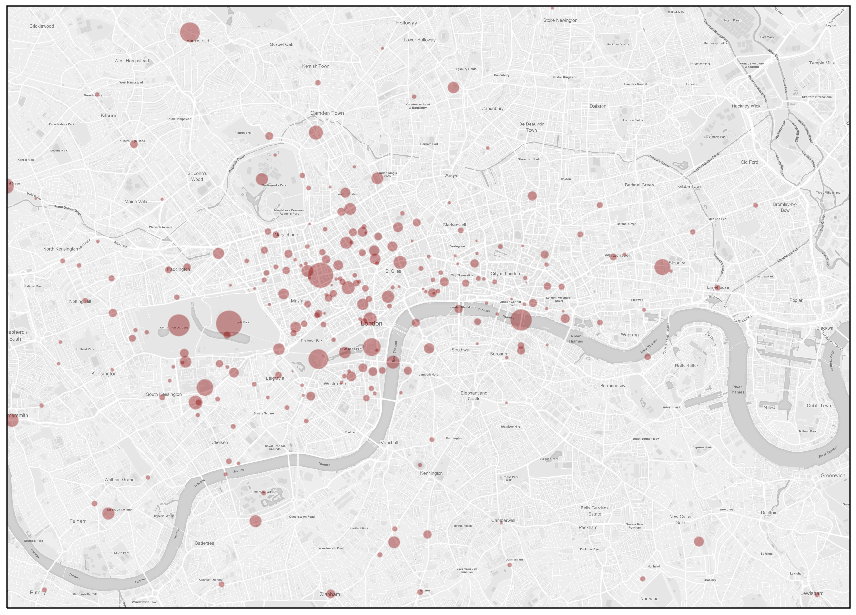

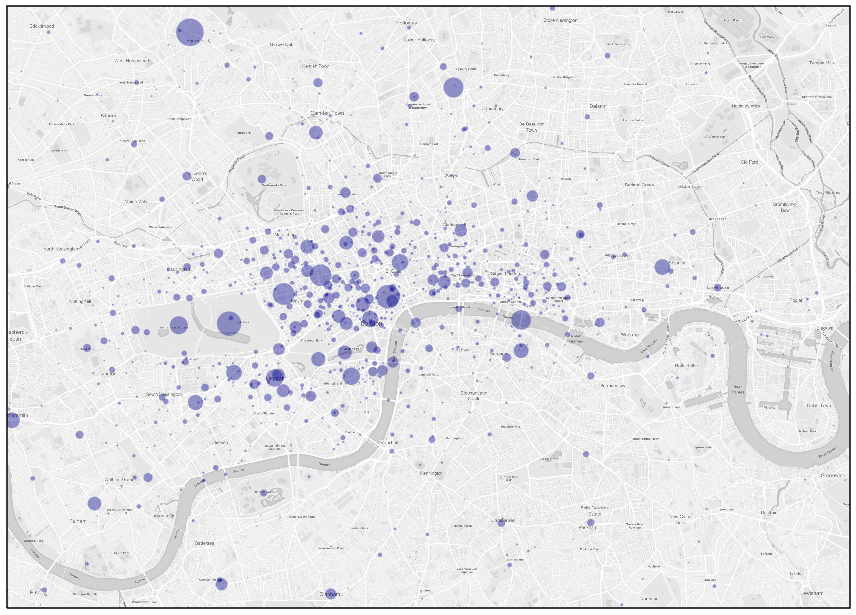

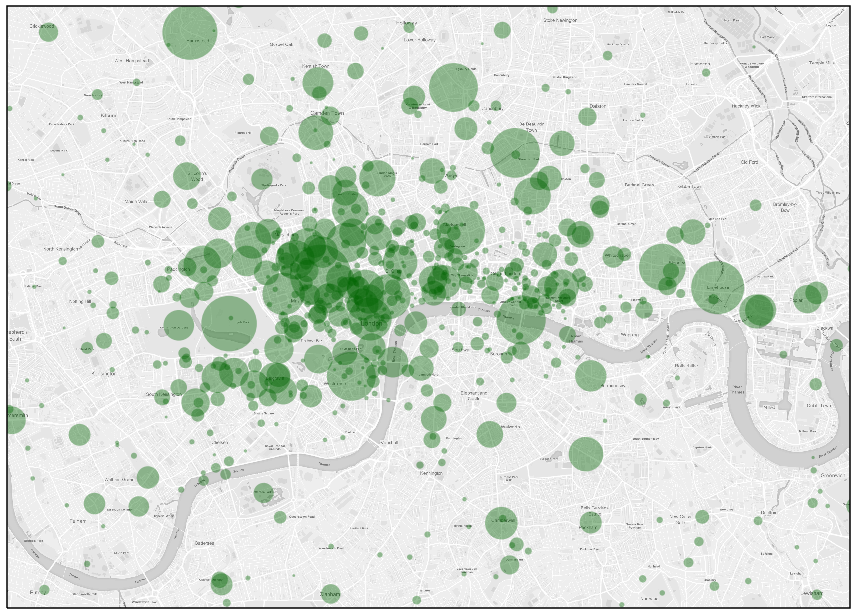

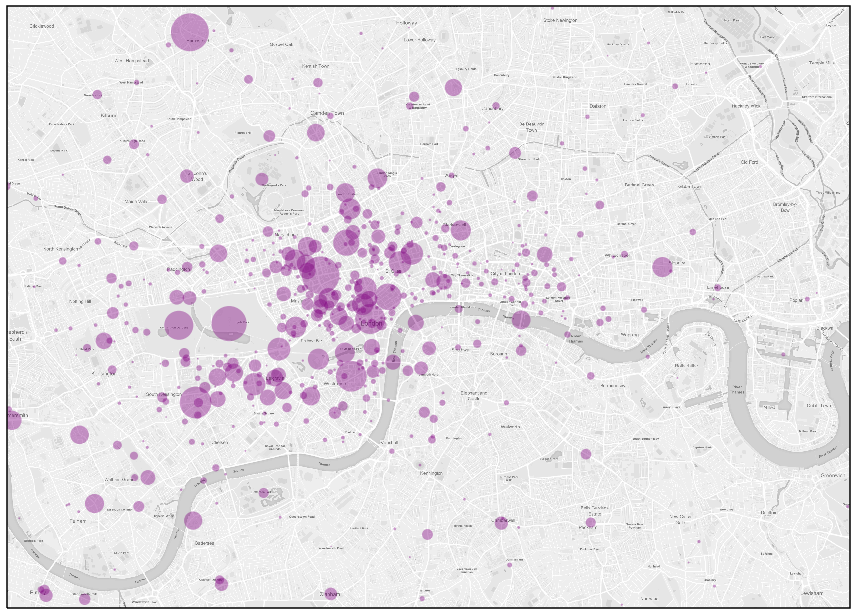

In [9]:
# London maps
for name, group in corpus_london_grouped:
    extent = [-0.225, 0, 51.46, 51.56]
    figsz = (12,9)
    figname = 'map-london-'+name
    london = group.loc[group.formatted_address != 'London, UK']
    latlons = london.groupby(['lat', 'lon']).occurs_100k.sum()/corpus_grouped.get_group(name).occurs_100k.sum()*1000000
    cities_tot = latlons.tolist()
    cities_lon = latlons.index.get_level_values('lon').tolist()
    cities_lat = latlons.index.get_level_values('lat').tolist()
    color = colors[name]
    bubblemap_london(figsz, cities_lat, cities_lon, cities_tot, color, extent, figname)

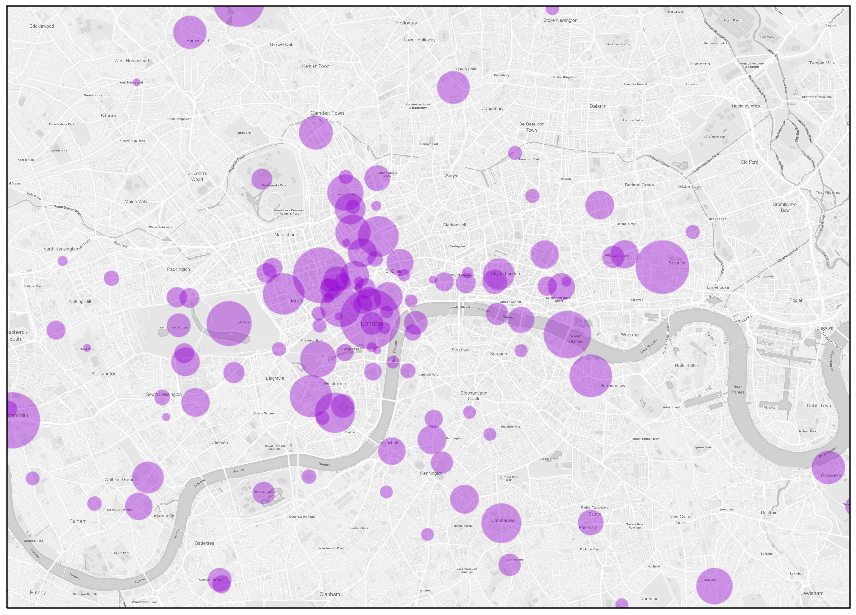

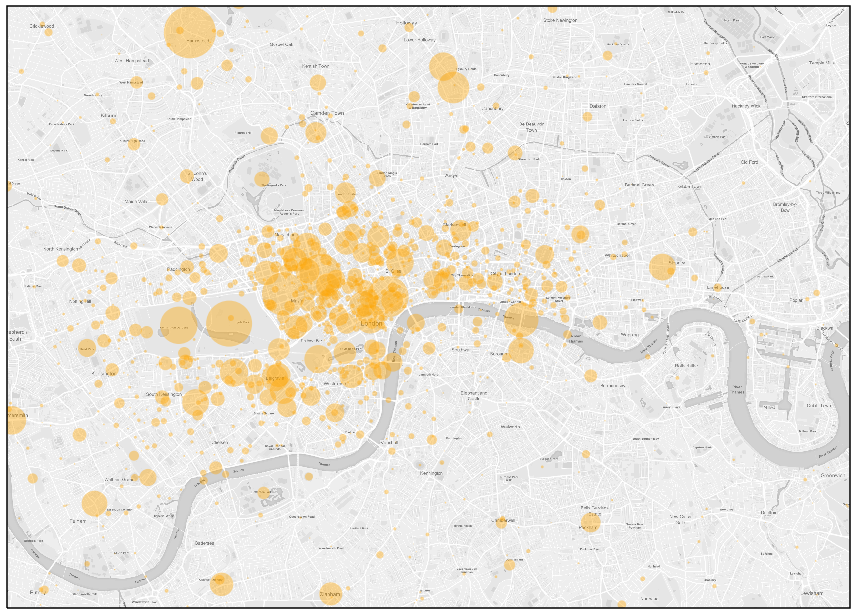

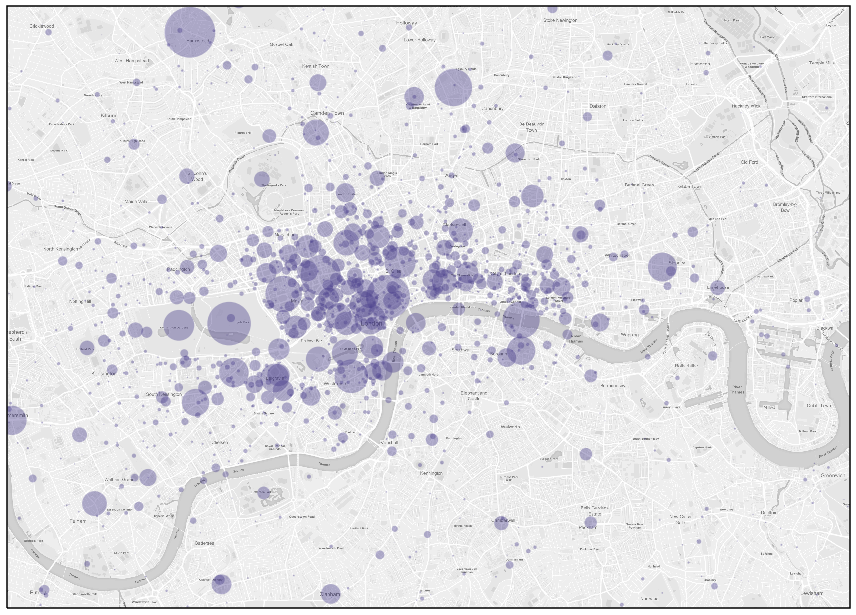

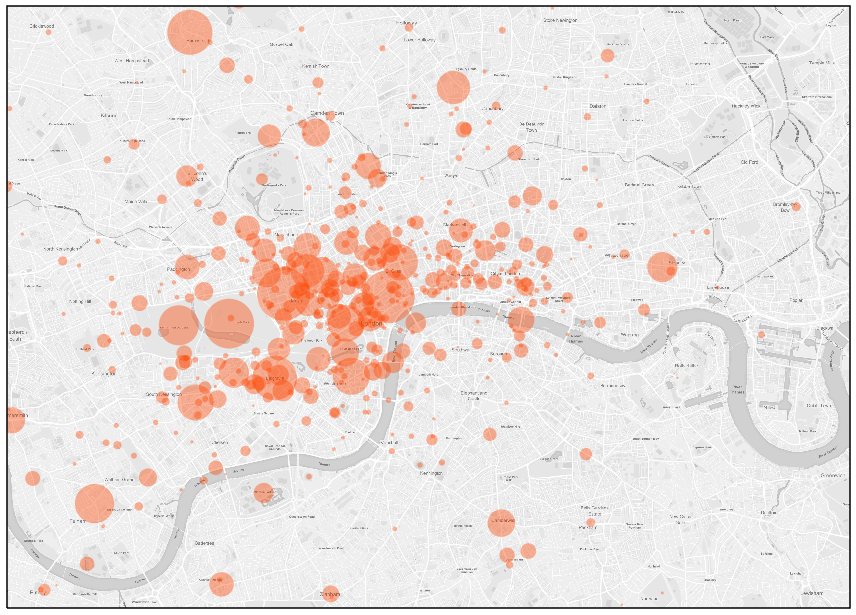

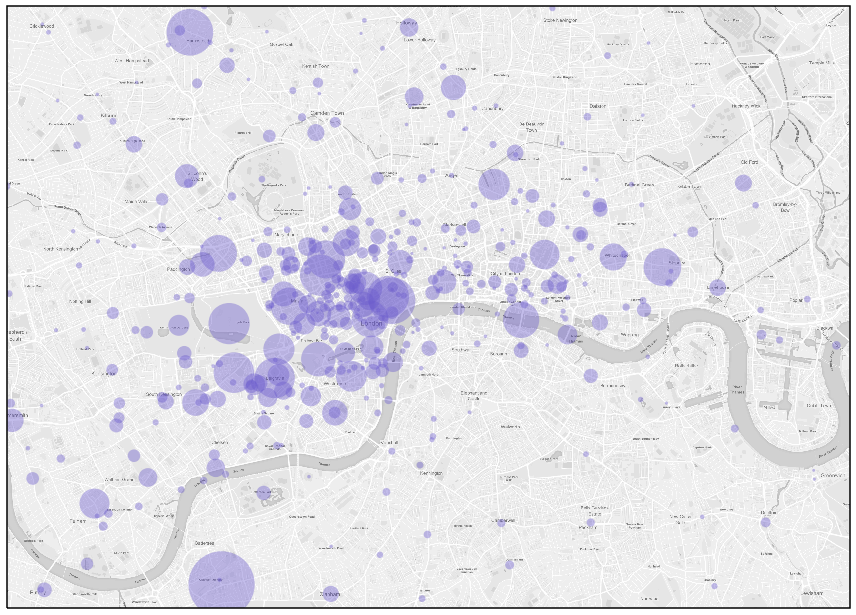

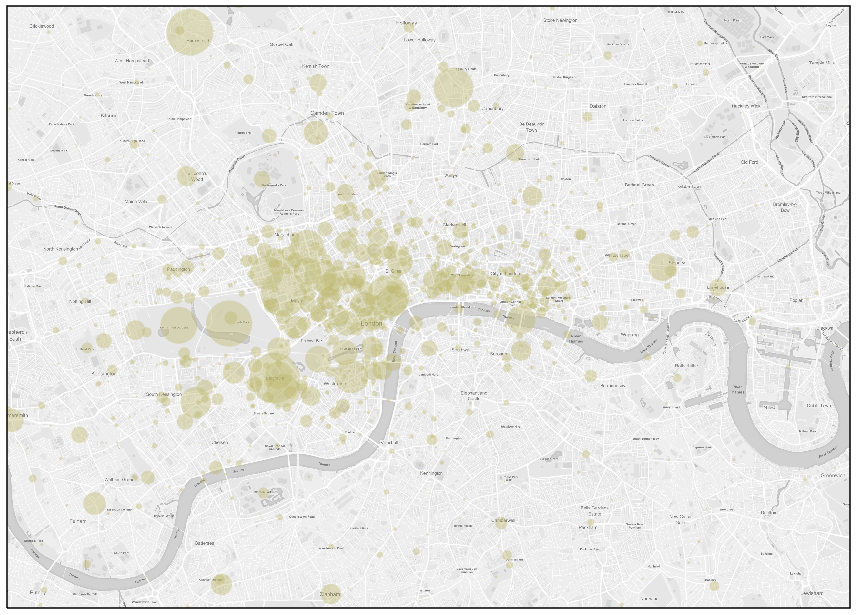

In [10]:
# ditto, just for gender in Hathi corpus
group  = corpus_london_grouped.get_group('Hathi')
london = group.loc[group.formatted_address != 'London, UK']
mf = london.groupby('gender')
for name, group in mf:
    extent = [-0.225, 0, 51.46, 51.56]
    figsz = (12,9)
    latlons = group.groupby(['lat', 'lon']).occurs_100k.sum()/mf.get_group(name).occurs_100k.sum()*100000
    cities_tot = latlons.tolist()
    cities_lon = latlons.index.get_level_values('lon').tolist()
    cities_lat = latlons.index.get_level_values('lat').tolist()
    color = colors[name]
    figname = 'map-london-Hathi-'+str.lower(name)
    bubblemap_london(figsz, cities_lat, cities_lon, cities_tot, color, extent, figname)

In [11]:
# Functions for confidence intervals and significance testing
def sig_label(pvalue):
    sig = ''
    if (np.array(pvalue) < 0.05).any():
        sig = '#'
    if (np.array(pvalue) < 0.01).any():
        sig = '##'
    if (np.array(pvalue) < 0.001).any():
        sig = '###'
    return(sig)

def compare_groups(df, column, weight, ci, filename, precision):
    done = []
    results = []
    for name, group in df:
        done.append(name)
        if weight is None:
            g1 = sms.DescrStatsW(group[column])
        else:
            g1 = sms.DescrStatsW(group[column], group[weight])
        g1_mean = g1.mean
        g1_low, g1_high = g1.tconfint_mean(alpha=1-ci)
        for name_target, group_target in df:
            if name_target not in done:
                if weight is None:
                    g2 = sms.DescrStatsW(group_target[column])
                    pval = sms.ttest_ind(group[column], group_target[column])[1]
                else:
                    g2 = sms.DescrStatsW(group_target[column],
                                         group_target[weight])
                    pval = sms.ttest_ind(group[column], group_target[column], 
                                         weights=(group[weight], group_target[weight]))[1]
                g2_mean = g2.mean
                g2_low, g2_high = g2.tconfint_mean(alpha=1-ci)
                sig = sig_label(pval)
                results.append((name, g1_low, g1_mean, g1_high, 
                                name_target, g2_low, g2_mean, g2_high,
                                pval, sig))
    labels = ['Group 1', 'Low 1', 'MEAN 1', 'High 1', 
              'Group 2', 'Low 2', 'MEAN 2', 'High 2', 
              'p-value', 'sig']
    df = pd.DataFrame.from_records(results, columns=labels)
    pd.set_option('precision', precision)
    df.to_csv(os.path.join(resultsDir, filename+'.tsv'), sep='\t', index=False)
    return(df)

In [12]:
# Centers of gravity
print("London centers of gravity by corpus")

cog_ignore = frozenset([
    'Thames',
    'River Thames',
    'Thames River'
])

# Build weighted dataframe
output = []
for name, group in corpus_london_grouped:
    reduced  = group.loc[(group.formatted_address != 'London, UK')]
    group_occurs = reduced.occurs_100k.sum()
    group_vols   = reduced.htid.nunique()
    avg_occurs   = group_occurs/group_vols
    byvol = reduced.groupby('htid')
    for htid, vol in byvol:
        weight = vol.occurs_100k.sum()/avg_occurs
        pub_date = vol.pub_date.values[0]
        ethnicity = vol.white.values[0]
        genre = vol.genre.values[0]
        genre_class = 'Fiction'
        if genre.startswith('Fic') == False:
            genre_class = 'Nonfiction'
        era = 'late'
        if pub_date < splitdate:
            era = 'early'
        gender = vol.gender.values[0]
        try:
            avg_lat = vol.loc[(~vol.text_string.isin(cog_ignore))].lat.multiply(vol.occurs_100k).sum() /\
                      vol.loc[(~vol.text_string.isin(cog_ignore))].occurs_100k.sum()
        except ZeroDivisionError:
            avg_lat = False
        try:
            avg_lon = vol.loc[(~vol.text_string.isin(cog_ignore))].lon.multiply(vol.occurs_100k).sum() /\
                      vol.loc[(~vol.text_string.isin(cog_ignore))].occurs_100k.sum()
        except ZeroDivisionError:
            avg_lon = False
        if avg_lat and avg_lon:
            output.append((name, pub_date, ethnicity, era, genre_class, gender, avg_lat, avg_lon, weight))
cog = pd.DataFrame.from_records(output)
cog.columns = ['corpus', 'pub_date', 'ethnicity', 'era', 'genre', 'gender', 'avg_lat', 'avg_lon', 'weight']

# Group and run tests
cogg = cog.groupby('corpus')
result = compare_groups(cogg, ['avg_lat', 'avg_lon'], 'weight', ci, 'cog_by_corpus', 3)
display(result)

cogg_early = cog.loc[(cog.era == 'early')].groupby('corpus')
cogg_late  = cog.loc[(cog.era == 'late')].groupby('corpus')
print("\nCenters of gravity, early")
result = compare_groups(cogg_early, ['avg_lat', 'avg_lon'], 'weight', ci, 
                        'cog_early_by_corpus', 3)
display(result)

print("\ncenters of gravity, late")
result = compare_groups(cogg_late, ['avg_lat', 'avg_lon'], 'weight', ci, 
                        'cog_late_by_corpus', 3)
display(result)

print("Centers of gravity by ethnicity in Foreign corpus")
result = compare_groups(cogg.get_group('Foreign').groupby('ethnicity'), ['avg_lat', 'avg_lon'],
                        'weight', ci, 'cog_by_ethnicity_in_foreign', 3)
display(result)

print("Centers of gravity by genre in Foreign corpus")
result = compare_groups(cogg.get_group('Foreign').groupby('genre'), ['avg_lat', 'avg_lon'],
                        'weight', ci, 'cog_by_genre_in_foreign', 3)
display(result)

print("Centers of gravity by gender in Hathi corpus")
result = compare_groups(cogg.get_group('Hathi').groupby('gender'), ['avg_lat', 'avg_lon'],
                        'weight', ci, 'cog_by_gender_in_Hathi', 3)
display(result)


print("Centers of gravity within corpora by era")
for name, group in cogg:
    result = compare_groups(group.groupby('era'), ['avg_lat', 'avg_lon'],
                            'weight', ci, 'cog_by_era_'+name, 3)
    display(name, result)

London centers of gravity by corpus


Group 1                                      Low 1  \
0  Foreign  [51.50708145748188, -0.17470043592230836]   
1  Foreign  [51.50708145748188, -0.17470043592230836]   
2  Foreign  [51.50708145748188, -0.17470043592230836]   
3    Hathi  [51.51062691429201, -0.16187672179935092]   
4    Hathi  [51.51062691429201, -0.16187672179935092]   
5   London  [51.51059350246798, -0.13480614183103015]   

                                       MEAN 1  \
0  [51.509791854938115, -0.16478990126723625]   
1  [51.509791854938115, -0.16478990126723625]   
2  [51.509791854938115, -0.16478990126723625]   
3   [51.510893134394884, -0.1610985729723462]   
4   [51.510893134394884, -0.1610985729723462]   
5   [51.51289621871217, -0.12913913338118782]   

                                       High 1    Group 2  \
0   [51.51250225239435, -0.15487936661216414]      Hathi   
1   [51.51250225239435, -0.15487936661216414]     London   
2   [51.51250225239435, -0.15487936661216414]  Prominent   
3   [51.51115935449776, -0.16032042414534148]     London   
4   [51.51115935449776, -0.16032042414534148]  Prominent   
5  [51.515198934956366, -0.12347212493134549]  Prominent   

                                       Low 2  \
0  [51.51062691429201, -0.16187672179935092]   
1  [51.51059350246798, -0.13480614183103015]   
2   [51.5046871279416, -0.16431916973441746]   
3  [51.51059350246798, -0.13480614183103015]   
4   [51.5046871279416, -0.16431916973441746]   
5   [51.5046871279416, -0.16431916973441746]   

                                      MEAN 2  \
0  [51.510893134394884, -0.1610985729723462]   
1  [51.51289621871217, -0.12913913338118782]   
2  [51.50665557008114, -0.15971481231165058]   
3  [51.51289621871217, -0.12913913338118782]   
4  [51.50665557008114, -0.15971481231165058]   
5  [51.50665557008114, -0.15971481231165058]   

                                       High 2  \
0   [51.51115935449776, -0.16032042414534148]   
1  [51.515198934956366, -0.12347212493134549]   
2   [51.508624012220686, -0.1551104548888837]   
3  [51.515198934956366, -0.12347212493134549]   
4   [51.508624012220686, -0.1551104548888837]   
5   [51.508624012220686, -0.1551104548888837]   

                                         p-value  sig  
0       [0.6727320680796655, 0.6281856908242103]       
1  [0.10262959043233565, 1.8246562034438804e-10]  ###  
2     [0.19679204263149716, 0.39040120877147166]       
3    [0.2859979209772952, 5.738947668691745e-09]  ###  
4    [0.0001449861224610031, 0.6705120365835253]  ###  
5  [0.000690990652335601, 3.562112937312708e-12]  ###


Centers of gravity, early


Group 1                                      Low 1  \
0  Foreign   [51.50671944767073, -0.1793281529121385]   
1  Foreign   [51.50671944767073, -0.1793281529121385]   
2  Foreign   [51.50671944767073, -0.1793281529121385]   
3    Hathi  [51.51069088496024, -0.16289934239325765]   
4    Hathi  [51.51069088496024, -0.16289934239325765]   
5   London  [51.50894475064193, -0.14017267963361277]   

                                      MEAN 1  \
0  [51.509695199536196, -0.1679624936691039]   
1  [51.509695199536196, -0.1679624936691039]   
2  [51.509695199536196, -0.1679624936691039]   
3  [51.51106094100987, -0.16180556874726618]   
4  [51.51106094100987, -0.16180556874726618]   
5  [51.51245302924763, -0.13189616401622228]   

                                      High 1    Group 2  \
0   [51.51267095140166, -0.1565968344260693]      Hathi   
1   [51.51267095140166, -0.1565968344260693]     London   
2   [51.51267095140166, -0.1565968344260693]  Prominent   
3  [51.511430997059506, -0.1607117951012747]     London   
4  [51.511430997059506, -0.1607117951012747]  Prominent   
5   [51.51596130785333, -0.1236196483988318]  Prominent   

                                       Low 2  \
0  [51.51069088496024, -0.16289934239325765]   
1  [51.50894475064193, -0.14017267963361277]   
2  [51.50101975469105, -0.17181804370768775]   
3  [51.50894475064193, -0.14017267963361277]   
4  [51.50101975469105, -0.17181804370768775]   
5  [51.50101975469105, -0.17181804370768775]   

                                       MEAN 2  \
0   [51.51106094100987, -0.16180556874726618]   
1   [51.51245302924763, -0.13189616401622228]   
2  [51.504159463055636, -0.16465335671265593]   
3   [51.51245302924763, -0.13189616401622228]   
4  [51.504159463055636, -0.16465335671265593]   
5  [51.504159463055636, -0.16465335671265593]   

                                      High 2  \
0  [51.511430997059506, -0.1607117951012747]   
1   [51.51596130785333, -0.1236196483988318]   
2  [51.50729917142022, -0.15748866971762412]   
3   [51.51596130785333, -0.1236196483988318]   
4  [51.50729917142022, -0.15748866971762412]   
5  [51.50729917142022, -0.15748866971762412]   

                                          p-value  sig  
0         [0.658757338619141, 0.5006980156960904]       
1      [0.255114582236491, 5.304028929501113e-07]  ###  
2         [0.0676313540740142, 0.651742446416997]       
3    [0.6029942879248543, 0.00015595986880123517]  ###  
4     [5.247119312469517e-05, 0.5714127172234356]  ###  
5  [0.0027766776385780645, 3.831355679036155e-07]  ###


centers of gravity, late


Group 1                                      Low 1  \
0  Foreign  [51.50337293950053, -0.17631734252421516]   
1  Foreign  [51.50337293950053, -0.17631734252421516]   
2  Foreign  [51.50337293950053, -0.17631734252421516]   
3    Hathi   [51.51030587224852, -0.1613266886732192]   
4    Hathi   [51.51030587224852, -0.1613266886732192]   
5   London   [51.51039276944715, -0.1339018777788848]   

                                      MEAN 1  \
0  [51.51009291856654, -0.15490786507358278]   
1  [51.51009291856654, -0.15490786507358278]   
2  [51.51009291856654, -0.15490786507358278]   
3   [51.51068708961115, -0.1602304737524249]   
4   [51.51068708961115, -0.1602304737524249]   
5   [51.513384059760774, -0.126104330382267]   

                                      High 1    Group 2  \
0  [51.516812897632555, -0.1334983876229504]      Hathi   
1  [51.516812897632555, -0.1334983876229504]     London   
2  [51.516812897632555, -0.1334983876229504]  Prominent   
3  [51.51106830697378, -0.15913425883163063]     London   
4  [51.51106830697378, -0.15913425883163063]  Prominent   
5   [51.5163753500744, -0.11830678298564923]  Prominent   

                                      Low 2  \
0  [51.51030587224852, -0.1613266886732192]   
1  [51.51039276944715, -0.1339018777788848]   
2  [51.50625743016546, -0.1615673438503538]   
3  [51.51039276944715, -0.1339018777788848]   
4  [51.50625743016546, -0.1615673438503538]   
5  [51.50625743016546, -0.1615673438503538]   

                                      MEAN 2  \
0   [51.51068708961115, -0.1602304737524249]   
1   [51.513384059760774, -0.126104330382267]   
2  [51.50873414633161, -0.15560235198890573]   
3   [51.513384059760774, -0.126104330382267]   
4  [51.50873414633161, -0.15560235198890573]   
5  [51.50873414633161, -0.15560235198890573]   

                                      High 2  \
0  [51.51106830697378, -0.15913425883163063]   
1   [51.5163753500744, -0.11830678298564923]   
2  [51.51121086249776, -0.14963736012745768]   
3   [51.5163753500744, -0.11830678298564923]   
4  [51.51121086249776, -0.14963736012745768]   
5  [51.51121086249776, -0.14963736012745768]   

                                         p-value  sig  
0        [0.9067668668138246, 0.715242836936764]       
1   [0.32940204644035787, 0.0024150274719094813]   ##  
2       [0.7643502467191746, 0.9499987478167906]       
3   [0.30150521146392956, 5.475426692531865e-06]  ###  
4     [0.17789283679710402, 0.26587808164584914]       
5  [0.056128348950065604, 9.252900497889871e-07]  ###

Centers of gravity by ethnicity in Foreign corpus


Group 1                                      Low 1  \
0  Nonwhite  [51.50689141787181, -0.17164319711216536]   

                                      MEAN 1  \
0  [51.509498314179325, -0.1636583266617042]   

                                      High 1 Group 2  \
0  [51.51210521048684, -0.15567345621124307]   White   

                                       Low 2  \
0  [51.501412770567846, -0.2112646183655304]   

                                       MEAN 2  \
0  [51.510985657876084, -0.16939190984094743]   

                                      High 2  \
0  [51.52055854518432, -0.12751920131636446]   

                                    p-value sig  
0  [0.6667470523011856, 0.6498195253261345]

Centers of gravity by genre in Foreign corpus


Group 1                                     Low 1  \
0  Fiction  [51.50633021591587, -0.1575537667270019]   

                                      MEAN 1  \
0  [51.51092635543837, -0.14755967332942754]   

                                     High 1     Group 2  \
0  [51.51552249496088, -0.1375655799318532]  Nonfiction   

                                       Low 2  \
0  [51.50573579499396, -0.18785656970404083]   

                                     MEAN 2  \
0  [51.50918515770337, -0.1740041163700719]   

                                      High 2  \
0  [51.51263452041278, -0.16015166303610298]   

                                      p-value sig  
0  [0.5459618659789173, 0.010653665260303024]   #

Centers of gravity by gender in Hathi corpus


Group 1                                       Low 1  \
0          androg    [51.50021084453532, -0.1639940519718239]   
1          androg    [51.50021084453532, -0.1639940519718239]   
2          androg    [51.50021084453532, -0.1639940519718239]   
3          androg    [51.50021084453532, -0.1639940519718239]   
4          androg    [51.50021084453532, -0.1639940519718239]   
5          female    [51.50738468193172, -0.1644399741282219]   
6          female    [51.50738468193172, -0.1644399741282219]   
7          female    [51.50738468193172, -0.1644399741282219]   
8          female    [51.50738468193172, -0.1644399741282219]   
9            male    [51.51070702025559, -0.1611877573835354]   
10           male    [51.51070702025559, -0.1611877573835354]   
11           male    [51.51070702025559, -0.1611877573835354]   
12  mostly_female  [51.508139427739216, -0.17841076455641594]   
13  mostly_female  [51.508139427739216, -0.17841076455641594]   
14    mostly_male   [51.50881790769368, -0.16453143780838433]   

                                        MEAN 1  \
0     [51.50784609550974, -0.1465494920499002]   
1     [51.50784609550974, -0.1465494920499002]   
2     [51.50784609550974, -0.1465494920499002]   
3     [51.50784609550974, -0.1465494920499002]   
4     [51.50784609550974, -0.1465494920499002]   
5    [51.50815423723051, -0.16271542985362109]   
6    [51.50815423723051, -0.16271542985362109]   
7    [51.50815423723051, -0.16271542985362109]   
8    [51.50815423723051, -0.16271542985362109]   
9    [51.51101515754802, -0.16021748797889188]   
10   [51.51101515754802, -0.16021748797889188]   
11   [51.51101515754802, -0.16021748797889188]   
12  [51.509735756472985, -0.17376564883203147]   
13  [51.509735756472985, -0.17376564883203147]   
14   [51.51137001600553, -0.15676949964278114]   

                                        High 1        Group 2  \
0    [51.515481346484165, -0.1291049321279765]         female   
1    [51.515481346484165, -0.1291049321279765]           male   
2    [51.515481346484165, -0.1291049321279765]  mostly_female   
3    [51.515481346484165, -0.1291049321279765]    mostly_male   
4    [51.515481346484165, -0.1291049321279765]        unknown   
5   [51.508923792529295, -0.16099088557902028]           male   
6   [51.508923792529295, -0.16099088557902028]  mostly_female   
7   [51.508923792529295, -0.16099088557902028]    mostly_male   
8   [51.508923792529295, -0.16099088557902028]        unknown   
9    [51.51132329484046, -0.15924721857424834]  mostly_female   
10   [51.51132329484046, -0.15924721857424834]    mostly_male   
11   [51.51132329484046, -0.15924721857424834]        unknown   
12     [51.51133208520675, -0.169120533107647]    mostly_male   
13     [51.51133208520675, -0.169120533107647]        unknown   
14  [51.513922124317375, -0.14900756147717795]        unknown   

                                         Low 2  \
0     [51.50738468193172, -0.1644399741282219]   
1     [51.51070702025559, -0.1611877573835354]   
2   [51.508139427739216, -0.17841076455641594]   
3    [51.50881790769368, -0.16453143780838433]   
4    [51.51302064439045, -0.16691097530525778]   
5     [51.51070702025559, -0.1611877573835354]   
6   [51.508139427739216, -0.17841076455641594]   
7    [51.50881790769368, -0.16453143780838433]   
8    [51.51302064439045, -0.16691097530525778]   
9   [51.508139427739216, -0.17841076455641594]   
10   [51.50881790769368, -0.16453143780838433]   
11   [51.51302064439045, -0.16691097530525778]   
12   [51.50881790769368, -0.16453143780838433]   
13   [51.51302064439045, -0.16691097530525778]   
14   [51.51302064439045, -0.16691097530525778]   

                                        MEAN 2  \
0    [51.50815423723051, -0.16271542985362109]   
1    [51.51101515754802, -0.16021748797889188]   
2   [51.509735756472985, -0.17376564883203147]   
3    [51.51137001600553, -0.15676949964278114]   
4    [51.51385361213679, -0.16447556204791564]   
5    [51.51101515754802, -

Centers of gravity within corpora by era


'Foreign'

Group 1                                     Low 1  \
0   early  [51.50671944767073, -0.1793281529121385]   

                                      MEAN 1  \
0  [51.509695199536196, -0.1679624936691039]   

                                     High 1 Group 2  \
0  [51.51267095140166, -0.1565968344260693]    late   

                                       Low 2  \
0  [51.50337293950053, -0.17631734252421516]   

                                      MEAN 2  \
0  [51.51009291856654, -0.15490786507358278]   

                                      High 2  \
0  [51.516812897632555, -0.1334983876229504]   

                                     p-value sig  
0  [0.9012944146455499, 0.26380848036353816]

'Hathi'

Group 1                                      Low 1  \
0   early  [51.51069088496024, -0.16289934239325765]   

                                      MEAN 1  \
0  [51.51106094100987, -0.16180556874726618]   

                                      High 1 Group 2  \
0  [51.511430997059506, -0.1607117951012747]    late   

                                      Low 2  \
0  [51.51030587224852, -0.1613266886732192]   

                                     MEAN 2  \
0  [51.51068708961115, -0.1602304737524249]   

                                      High 2  \
0  [51.51106830697378, -0.15913425883163063]   

                                      p-value sig  
0  [0.17099755845035355, 0.04845888760422179]   #

'London'

Group 1                                      Low 1  \
0   early  [51.50894475064193, -0.14017267963361277]   

                                      MEAN 1  \
0  [51.51245302924763, -0.13189616401622228]   

                                     High 1 Group 2  \
0  [51.51596130785333, -0.1236196483988318]    late   

                                      Low 2  \
0  [51.51039276944715, -0.1339018777788848]   

                                     MEAN 2  \
0  [51.513384059760774, -0.126104330382267]   

                                     High 2  \
0  [51.5163753500744, -0.11830678298564923]   

                                     p-value sig  
0  [0.6913978726626586, 0.31503405759920666]

'Prominent'

Group 1                                      Low 1  \
0   early  [51.50101975469105, -0.17181804370768775]   

                                       MEAN 1  \
0  [51.504159463055636, -0.16465335671265593]   

                                      High 1 Group 2  \
0  [51.50729917142022, -0.15748866971762412]    late   

                                      Low 2  \
0  [51.50625743016546, -0.1615673438503538]   

                                      MEAN 2  \
0  [51.50873414633161, -0.15560235198890573]   

                                      High 2  \
0  [51.51121086249776, -0.14963736012745768]   

                                       p-value sig  
0  [0.022827336703101855, 0.05436528333329055]   #

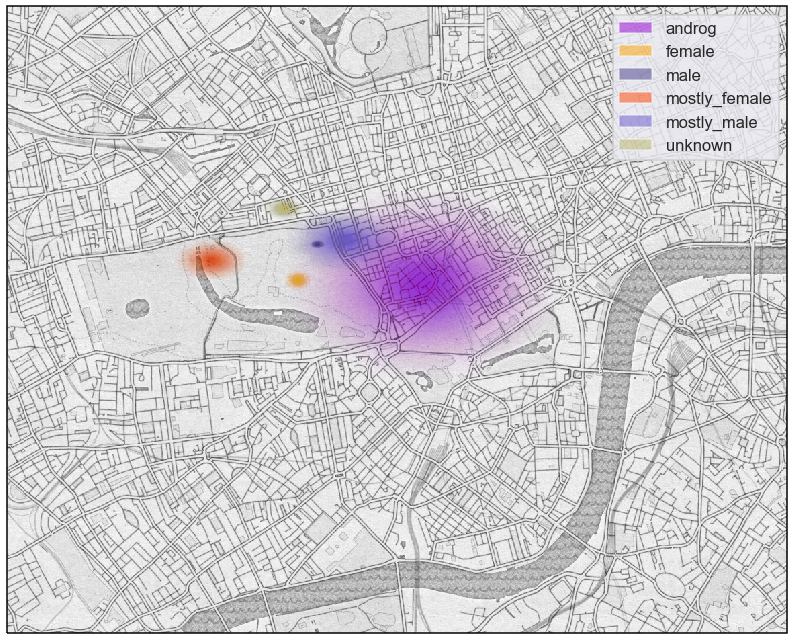

In [13]:
# Gender in Hathi
steps=100
fig = plt.figure(figsize=(12,9))
imagery = MapboxTiles(mapbox_key, 'mapbox.pencil')
ax = plt.axes(projection=imagery.crs)
extent = [-0.20, -0.10, 51.48, 51.53]
ax.set_extent(extent)
ax.add_image(imagery, 14)

for name, group in cogg.get_group('Hathi').groupby('gender'):
    #group = group.loc[group.gender.isin(['male', 'female'])]
    model = sms.DescrStatsW(group[['avg_lat', 'avg_lon']], group['weight'])
    x = model.mean[1]
    y = model.mean[0]
    for i in range(steps):
        low, high = model.tconfint_mean(0.05 + 0.9*i/steps)
        width = high[1]-low[1]
        height = high[0]-low[0]
        lab = None
        if i == 1:
            lab = name
        ax.add_patch(
            Ellipse(
                (x,y), 
                width, 
                height,
                transform=ccrs.Geodetic(), alpha=1/steps, color=colors[name], label = lab) 
        )
        
# Build the legend
markers = []
texts = []
for name, group in cogg.get_group('Hathi').groupby('gender'):
    markers.append(Rectangle((0,0), 1, 2, fc=colors[name], alpha=0.5))
    texts.append(name)
plt.legend(markers, texts)
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(figDir, 'cog_by_gender_in_Hathi')+'.png', dpi=300)

In [14]:
# Get gender counts in Hathi corpus
geo.loc[geo.corpus=='Hathi'].groupby('gender').htid.nunique()

gender
androg              95
female            9249
male             27389
mostly_female      882
mostly_male        424
unknown           6740
Name: htid, dtype: int64